# SubstateDecoding.ipynb
## Substate position decoding—blending states for higher spatial resolution

Although we may like to think of our HMM states as virtual place cells (and hence a finite number of them), the positions that they encode are not discrete but rather continuous in nature. Consequently, when we decode a sequence of observations, we get an associated sequence of state distributions. Instead of simply using the state sequence corresponding to the most likely sequence at each time step (so-called symbol-by-symbol MAP decoding), we can get a more accurate estimate of the underlying position by _combining_ all the state information. That is, we take a weighted average of our decoded states as the position estimate.

More specifically, we will look at three approaches to decoding position: (i) by taking a virtual cell's (state's) position as the **mode** of the estimated place field and to choose the most likely state as the position, (ii) by taking a virtual cell's (state's) position as the **mean** of the estimated place field and to choose the most likely state as the position, and (iii) by using either the mean or the mode of the estimated place field as a cell's position, but then to **combine** those positions, the so-called substate decoding approach.

The idea to consider substates (or mixtures of states) seems very natural, and indeed, it is closely related to other approaches to decoding spatial activity where the underlying position is viewed as a continuous variable.

**Note:** Ordering place fields by peak location (that is, using the _mode_) is very common, but is perhaps most appropriate when the place fields are _multimodal_. If the placefields are _unimodal_, then ordering by the _mean_ of the place field might be more appropriate. 

**Old phrasing:** In most HMMs, the states are assumed to be mutually exclusive events. For example, either it is rainy, or it is sunny. However, occasionally, a system can be in multiple states at once: it could be rainy while the sun is still shining (so-called sunshowers). In our case, we have states corresponding to virtual place cells, with associated place fields. When decoding the underlying sequence of states, we actually get back a _distribution_ over the states. So instead of declaring the system to be in a particular state (the most likely state) at time $t$, we can reasonably expect the system to be somewhere _between_ several states, just like an animal's position is likely to be somewhere between the modes of several place fields. 

**TODO:** refine the above, and finish argument.

**Note:** Two complementary views exist, namely the (i) state distribution per position, and the (ii) position distribution per state. The first reveals how \_\_\_\_\_\_\_? If there are only a few states, then substate decoding might not help much; if there are many states, then perhaps \_\_\_\_\_\_\_. This is not hard to hypothesize about, but I want to make sure I believe what I write down first. In the second case, we can see how wide a particular place field is. 

**Related questions for future work:** Q. Can we do any better by smoothing the spike trains first? Or by smoothing the place fields? (tuning curves?) FFB! How do we perform substate decoding in the absence of position data? Do we use MDS?

### Import packages and initialization

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys

sys.path.insert(0, 'helpers')

from efunctions import * # load my helper function(s) to save pdf figures, etc.
from hc3 import load_data, get_sessions
from hmmlearn import hmm # see https://github.com/ckemere/hmmlearn
import klabtools as klab
import seqtools as sq

import importlib

importlib.reload(sq) # reload module here only while prototyping...
importlib.reload(klab) # reload module here only while prototyping...

%matplotlib inline

sns.set(rc={'figure.figsize': (12, 4),'lines.linewidth': 1.5})
sns.set_style("white")

function saveFigure(filename) loaded

Tip: to save a figure, call saveFigure("path/figure.pdf")


### Define helper function(s)

In [2]:
from mymap import Map

def extract_subsequences_from_binned_spikes(binned_spikes, bins):
    data = spikes.data.copy()
    boundaries = klab.get_continuous_segments(bins)
    
    binned = Map()
    binned['bin_width'] = binned_spikes.bin_width
    binned['data'] = binned_spikes.data[bins,:]
    binned['boundaries'] = boundaries
    binned['boundaries_fs'] = 1/binned_spikes.bin_width   
    binned['sequence_lengths'] = (boundaries[:,1] - boundaries[:,0] + 1).flatten()
    
    return binned

### Load data

Here we consider lin2 data for gor01 on the first recording day (6-7-2006), since this session had the most units (91) of all the gor01 sessions, and lin2 has position data, whereas lin1 only has partial position data.

In [3]:
datadirs = ['/home/etienne/Dropbox/neoReader/Data',
            'C:/etienne/Dropbox/neoReader/Data',
            '/Users/etienne/Dropbox/neoReader/Data']

fileroot = next( (dir for dir in datadirs if os.path.isdir(dir)), None)

animal = 'gor01'; month,day = (6,7); session = '16-40-19' # 91 units

spikes = load_data(fileroot=fileroot, datatype='spikes',animal=animal, session=session, month=month, day=day, fs=32552, verbose=False)
eeg = load_data(fileroot=fileroot, datatype='eeg', animal=animal, session=session, month=month, day=day,channels=[0,1,2], fs=1252, starttime=0, verbose=False)
posdf = load_data(fileroot=fileroot, datatype='pos',animal=animal, session=session, month=month, day=day, verbose=False)
speed = klab.get_smooth_speed(posdf,fs=60,th=8,cutoff=0.5,showfig=False,verbose=False)

reading position data from '/home/etienne/Dropbox/neoReader/Data/gor01-6-7/2006-6-7_16-40-19/2006-6-7_16-40-19.whl'


### Bin data and train model

We start by training a model on RUN > 8 data in 125 ms bins. We then compute the (posterior) distribution over states at each time step. If we take the most likely state at each time step, we get the symbol-by-symbol maximum a posteriori sequence of states. However, this symbol-by-symbol MAP sequence _might_ not be a valid sequence through the model! So a popular (and sometimes superior) sequence is obtained by the celebrated Viterbi or maximum likleihood sequence estimate (MLSE).

In [4]:
## bin ALL spikes
ds = 0.125 # bin spikes into 125 ms bins (theta-cycle inspired)
binned_spikes = klab.bin_spikes(spikes.data, ds=ds, fs=spikes.samprate, verbose=True)

centerx = (np.array(posdf['x1']) + np.array(posdf['x2']))/2
centery = (np.array(posdf['y1']) + np.array(posdf['y2']))/2

tend = len(speed.data)/speed.samprate # end in seconds
time_axis = np.arange(0,len(speed.data))/speed.samprate
speed_125, tvel_125 = klab.resample_velocity(velocity=speed.data,t_bin=ds,tvel=time_axis,t0=0,tend=tend)
truepos_125 = np.interp(np.arange(0,len(binned_spikes.data))*ds,time_axis,centerx)

# get bins where rat was running faster than thresh units per second
runidx_125 = np.where(speed_125>8)[0]
seq_stk_run_125 = extract_subsequences_from_binned_spikes(binned_spikes,runidx_125)

## split data into train, test, and validation sets:
tr_b2,vl_b2,ts_b2 = sq.data_split(seq_stk_run_125, tr=60, vl=10, ts=30, randomseed = 0, verbose=True)

## train HMM on active behavioral data; training set (with a fixed, arbitrary number of states for now):
num_states = 35
myhmm2 = sq.hmm_train(tr_b2, num_states=num_states, n_iter=50, verbose=False)

binning data into 20703 x 125.0 ms temporal bins...
Splitting 90 sequences into train, validation, and test sets...
54 sequences being stacked...
Total sequence length: 1135 bins, each of width 0.125 seconds
Successfully stacked 54 sequences for a total of 141.88 seconds of data.
9 sequences being stacked...
Total sequence length: 170 bins, each of width 0.125 seconds
Successfully stacked 9 sequences for a total of 21.25 seconds of data.
27 sequences being stacked...
Total sequence length: 591 bins, each of width 0.125 seconds
Successfully stacked 27 sequences for a total of 73.88 seconds of data.
Stacked data split into train (60.0 %), validation (10.0 %) and test (30.0 %) sequences.


### Estimate place fields for RUN > 8 data

In order to assess the decoding accuracy, as well as to facilitate more clear visualization, we first proceed to learn/estimate the virtual place fields.

In [5]:
###########################################################3
stacked_data = seq_stk_run_125
###########################################################3

x0=0; xl=100; num_pos_bins=50
xx_left = np.linspace(x0,xl,num_pos_bins+1)
num_sequences = len(stacked_data.sequence_lengths)
num_states = myhmm2.n_components
state_pos = np.zeros((num_states, num_pos_bins)) # place fields

for seq_id in np.arange(0,num_sequences):
    tmpseqbdries = [0]; tmpseqbdries.extend(np.cumsum(stacked_data.sequence_lengths).tolist());
    obs = stacked_data.data[tmpseqbdries[seq_id]:tmpseqbdries[seq_id+1],:]
    ll, pp = myhmm2.score_samples(obs)
    xx = truepos_125[stacked_data.boundaries[seq_id,0]:stacked_data.boundaries[seq_id,1]+1]
    digitized = np.digitize(xx, xx_left) - 1 # spatial bin numbers
    for ii, ppii in enumerate(pp):
        state_pos[:,digitized[ii]] += np.transpose(ppii)

Below we take a look at a particular placefield, and where the mean and mode for this place field would lie.

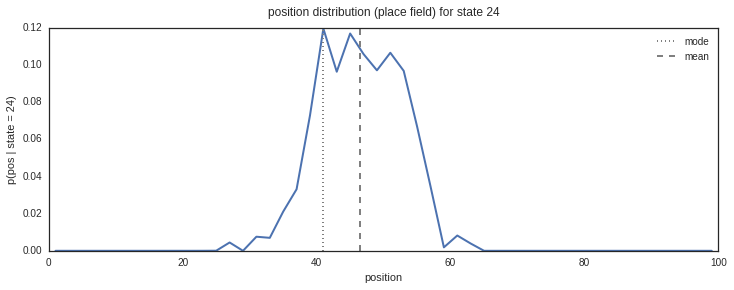

In [6]:
# select state to consider:
cc = 24

x0=0; xl=100; num_pos_bins=50
xx_mid = np.linspace(x0,xl,num_pos_bins+1)[:-1]; xx_mid += (xx_mid[1]-xx_mid[0])/2
#plt.plot(xx_mid,state_pos[24,:])

tmp = state_pos[cc,:]; tmp = tmp/tmp.sum()

plt.plot(xx_mid,tmp, linewidth=2)

pfmean = (tmp*xx_mid).sum()
pfmode = xx_mid[tmp.argmax()]

plt.axvline(x=pfmode, ymin=0, ymax=1, linewidth=2, color = 'gray', linestyle='dotted', label='mode')
plt.axvline(x=pfmean, ymin=0, ymax=1, linewidth=2, color = 'gray', linestyle='dashed', label='mean')
plt.legend()
plt.xlabel('position')
plt.ylabel('p(pos | state = {})'.format(cc))
plt.title('position distribution (place field) for state {}'.format(cc), y=1.03)
#vlines(x, ymin, ymax, colors='k', linestyles='solid', label='', hold=None, data=None
#ax3.plot([7, 7], [0, num_states], color='gray', linestyle='dashed', linewidth=1)

**Remarks:** As argued before, since this place field is _unimodal_, assigning its position as the mean of the place field might be more appropriate than using its mode. However, if we first smoothed the place field, then most likely the mean and the mode would coincide.

Next we look at _all_ the place fields learned by the HMM.

In [7]:
x0=0; xl=100; num_pos_bins=50
xx_mid = np.linspace(x0,xl,num_pos_bins+1)[:-1]; xx_mid += (xx_mid[1]-xx_mid[0])/2

# normalize place fields:
placefields = state_pos.copy()
colsum = np.tile(placefields.sum(axis=1),(num_pos_bins,1)).T
placefields = placefields/colsum

# determine mean for each place field:
pfmeans = (np.tile(xx_mid,(num_states,1))*placefields).sum(axis=1)
pfmodes = xx_mid[placefields.argmax(axis=1)]

# order place fields by mean or mode:
mean_order = pfmeans.argsort()
mode_order = pfmodes.argsort()

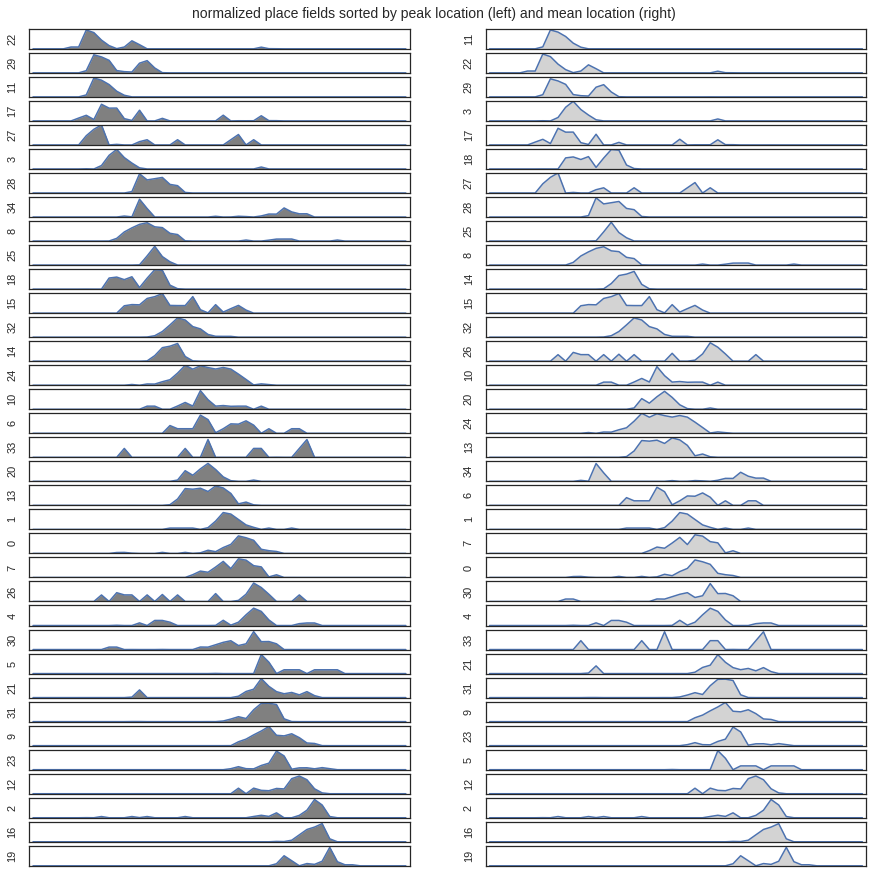

In [8]:
fig, axes = plt.subplots(num_states, 2, figsize=(15, 15))
axes = [item for sublist in axes for item in sublist]

for ii, ax in enumerate(axes):
    if ii % 2 == 0:
        idx = int(ii/2)
        ax.plot(xx_mid,placefields[mode_order[idx],:])
        ax.fill_between(xx_mid, 0, placefields[mode_order[idx]], color='gray')
        ax.set_ylabel(mode_order[idx])
    else:
        idx = int((ii-1)/2)
        ax.plot(xx_mid,placefields[mean_order[idx],:])
        ax.fill_between(xx_mid, 0, placefields[mean_order[idx]], color='lightgray')
        ax.set_ylabel(mean_order[idx])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
fig.suptitle('normalized place fields sorted by peak location (left) and mean location (right)', y=0.92, fontsize=14)

## Part 1: Symbol-by-symbol maximum a posteriori (MAP) state [position] decoding

Here we are primarily interested in the posterior state distributions, and we don't actually ever expect symbol-by-symbol MAP sequences to exist that are impossible in our model. To decode the states further to actual positions, we then associate with each state a position derived either from the mode of its place field, or from the mean of its place field. We refer to these decoding methods simply as 'mode' and 'mean' decoding.

First, let's look at some posterior state distributions for a few observation sequences:

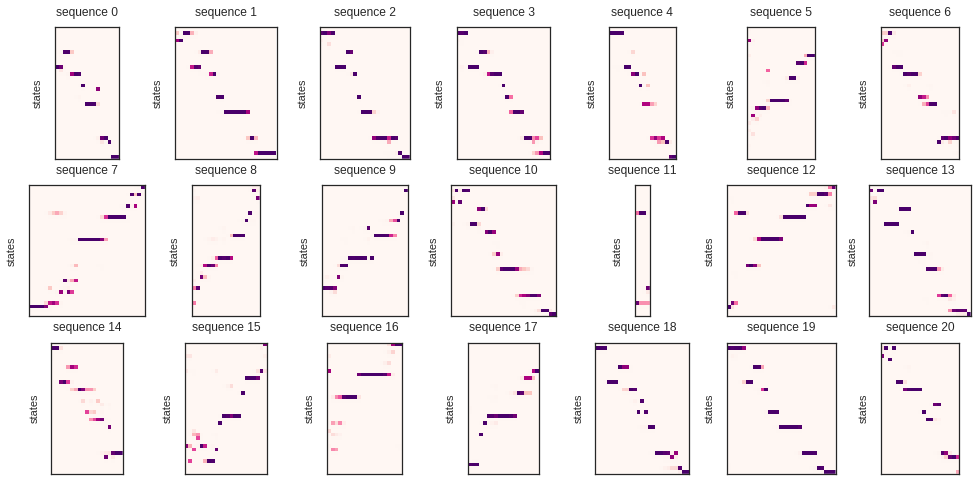

In [9]:
## order states by peak location on track

tmpseqbdries = [0]; tmpseqbdries.extend(np.cumsum(ts_b2.sequence_lengths).tolist());

fig, axes = plt.subplots(3, 7, figsize=(17, 8))
axes = [item for sublist in axes for item in sublist]

for ii, ax in enumerate(axes):
    obs = ts_b2.data[tmpseqbdries[ii]:tmpseqbdries[ii+1],:]
    ll, pp = myhmm2.score_samples(obs)
    ax.matshow(np.transpose(pp)[mode_order,:], interpolation='none', cmap='RdPu')
    #ax.axison = False
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title('sequence ' + str(ii))
    ax.set_ylabel('states')
    

Let's take a closer look at sequences 7 and 14, for example.

Saving figure to 'posterfigs/seqraw.pdf'...
Done


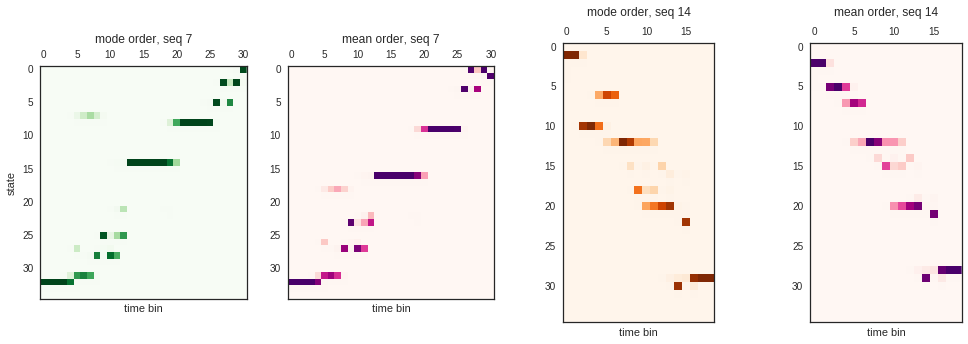

In [10]:
tmpseqbdries = [0]; tmpseqbdries.extend(np.cumsum(ts_b2.sequence_lengths).tolist());

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(17, 5))

seq_id = 7
obs = ts_b2.data[tmpseqbdries[seq_id]:tmpseqbdries[seq_id+1],:]
ll, pp = myhmm2.score_samples(obs)

ax1.matshow(np.transpose(pp)[mode_order,:], interpolation='none', cmap='Greens')
ax2.matshow(np.transpose(pp)[mean_order,:], interpolation='none', cmap='RdPu')
ax1.set_ylabel('state')
ax1.set_xlabel('time bin')
ax2.set_xlabel('time bin')
ax1.set_title('mode order, seq {}'.format(seq_id),y=1.08)
ax2.set_title('mean order, seq {}'.format(seq_id),y=1.08)
    
seq_id = 14
obs = ts_b2.data[tmpseqbdries[seq_id]:tmpseqbdries[seq_id+1],:]
ll, pp = myhmm2.score_samples(obs)

ax3.matshow(np.transpose(pp)[mode_order,:], interpolation='none', cmap='Oranges')
ax4.matshow(np.transpose(pp)[mean_order,:], interpolation='none', cmap='RdPu')
ax3.set_xlabel('time bin')
ax4.set_xlabel('time bin')
ax3.set_title('mode order, seq {}'.format(seq_id),y=1.08)
ax4.set_title('mean order, seq {}'.format(seq_id),y=1.08)

saveFigure('posterfigs/seqraw.pdf')


**Remarks:** Are the above sequences continuous? They look _somewhat_ continuous, but not exactly. The problem is that state-adjecency is not exactly equivalent to positional continuity. Nevertheless, the jump discontinuous nature of the sequences stem from the fact that the rat is running faster than the positions encoded by adjacent states. That is, the rat is running at 3 states per time bin, or something like that.

So how can we get a better idea about whether or not the above sequences actually correspond to contunuous trajectories in the environment? We further decode them to their underlying positions, shown next.

## Part 2: Decoding positions from state sequences

Here we decode state sequences (symbol-by-symbol MAP sequences) to their associated position sequences on the track.

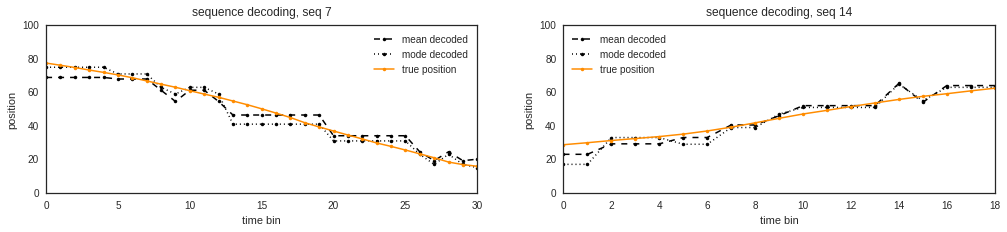

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 3))

seq_id = 7

obs = ts_b2.data[tmpseqbdries[seq_id]:tmpseqbdries[seq_id+1],:]
ll, pp = myhmm2.score_samples(obs)
seq_len = len(obs)

mean_pos = pfmeans[pp.argmax(axis=1)]
mode_pos = pfmodes[pp.argmax(axis=1)]

# true position:
bb = ts_b2.boundaries[seq_id,:] # inclusive
true_pos = truepos_125[bb[0]:bb[1]+1]

ax1.plot(mean_pos, '.', markersize=7, label='mean decoded', linestyle='dashed', linewidth=1.5, color='k')
ax1.plot(mode_pos, '.', markersize=7, label='mode decoded', linestyle='dotted', linewidth=1.5, color='k')
ax1.plot(true_pos,'.',markersize=7, label='true position', linestyle='solid', color='darkorange', linewidth=1.5)

ax1.set_ylim([0,100])
ax1.legend()
ax1.set_ylabel('position')
ax1.set_xlabel('time bin')
ax1.set_title('sequence decoding, seq {}'.format(seq_id), y=1.03)

seq_id = 14

obs = ts_b2.data[tmpseqbdries[seq_id]:tmpseqbdries[seq_id+1],:]
ll, pp = myhmm2.score_samples(obs)
seq_len = len(obs)

mean_pos = pfmeans[pp.argmax(axis=1)]
mode_pos = pfmodes[pp.argmax(axis=1)]

# true position:
bb = ts_b2.boundaries[seq_id,:] # inclusive
true_pos = truepos_125[bb[0]:bb[1]+1]

ax2.plot(mean_pos, '.', markersize=7, label='mean decoded', linestyle='dashed', linewidth=1.5, color='k')
ax2.plot(mode_pos, '.', markersize=7, label='mode decoded', linestyle='dotted', linewidth=1.5, color='k')
ax2.plot(true_pos,'.',markersize=7, label='true position', linestyle='solid', color='darkorange', linewidth=1.5)

ax2.set_ylim([0,100])
ax2.legend(loc='upper left')
ax2.set_ylabel('position')
ax2.set_xlabel('time bin')
ax2.set_title('sequence decoding, seq {}'.format(seq_id), y=1.03)

**Remarks:** Note that the decoded positions generally follow the true position fairly well, but that the decoded positions seem to be piece-wise constant. That is expected, because there are only a relatively small number of discrete states, each with its associated position.

Next, we look at substate decoding, where we decode the position as a weighted combination of the positions of all the participating states at any given time.

mean decoding error: 4.072
mode decoding error: 5.425
substate decoding error: 3.584


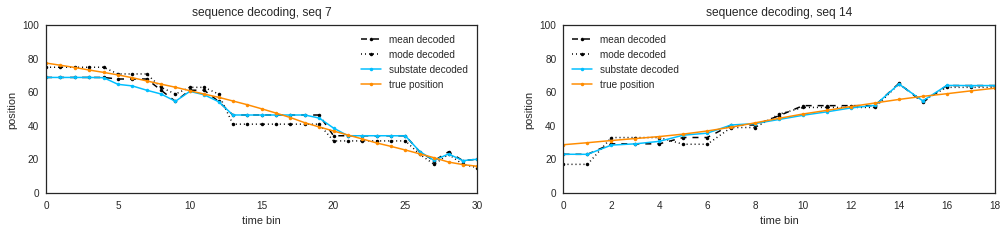

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 3))

seq_id = 7

obs = ts_b2.data[tmpseqbdries[seq_id]:tmpseqbdries[seq_id+1],:]
ll, pp = myhmm2.score_samples(obs)
seq_len = len(obs)

mean_pos = pfmeans[pp.argmax(axis=1)]
mode_pos = pfmodes[pp.argmax(axis=1)]
substate_pos = (pp*np.tile(pfmeans,(seq_len,1))).sum(axis=1)

# true position:
bb = ts_b2.boundaries[seq_id,:] # inclusive
true_pos = truepos_125[bb[0]:bb[1]+1]

ax1.plot(mean_pos, '.', markersize=7, label='mean decoded', linestyle='dashed', linewidth=1.5, color='k')
ax1.plot(mode_pos, '.', markersize=7, label='mode decoded', linestyle='dotted', linewidth=1.5, color='k')
ax1.plot(substate_pos,'.',markersize=7, label='substate decoded', linestyle='solid', color='deepskyblue', linewidth=1.5)
ax1.plot(true_pos,'.',markersize=7, label='true position', linestyle='solid', color='darkorange', linewidth=1.5)

ax1.set_ylim([0,100])
ax1.legend()
ax1.set_ylabel('position')
ax1.set_xlabel('time bin')
ax1.set_title('sequence decoding, seq {}'.format(seq_id), y=1.03)

seq_id = 14

obs = ts_b2.data[tmpseqbdries[seq_id]:tmpseqbdries[seq_id+1],:]
ll, pp = myhmm2.score_samples(obs)
seq_len = len(obs)

mean_pos = pfmeans[pp.argmax(axis=1)]
mode_pos = pfmodes[pp.argmax(axis=1)]
substate_pos = (pp*np.tile(pfmeans,(seq_len,1))).sum(axis=1)


# true position:
bb = ts_b2.boundaries[seq_id,:] # inclusive
true_pos = truepos_125[bb[0]:bb[1]+1]

ax2.plot(mean_pos, '.', markersize=7, label='mean decoded', linestyle='dashed', linewidth=1.5, color='k')
ax2.plot(mode_pos, '.', markersize=7, label='mode decoded', linestyle='dotted', linewidth=1.5, color='k')
ax2.plot(substate_pos,'.',markersize=7, label='substate decoded', linestyle='solid', color='deepskyblue', linewidth=1.5)
ax2.plot(true_pos,'.',markersize=7, label='true position', linestyle='solid', color='darkorange', linewidth=1.5)

ax2.set_ylim([0,100])
ax2.legend(loc='upper left')
ax2.set_ylabel('position')
ax2.set_xlabel('time bin')
ax2.set_title('sequence decoding, seq {}'.format(seq_id), y=1.03)

errors = [np.sqrt(((true_pos - mean_pos)**2).mean()), np.sqrt(((true_pos -mode_pos)**2).mean()), np.sqrt(((true_pos - substate_pos)**2).mean())]
print('mean decoding error: {:2.3f}\nmode decoding error: {:2.3f}\nsubstate decoding error: {:2.3f}'.format(errors[0],errors[1],errors[2]))

#saveFigure('posterfigs/decode.pdf')

**Remarks:** We see that the substate decoded positions take on more values than the mean and mode decoded approahces, and we see that it generally follows the true position more closely. To quantify how much better substate decoding does than meand and mode decoding, we compute the RMSE from  the true position, and we summarize the results below:

In [13]:
## compute decoding errors

data = ts_b2
num_test_sequences = len(data.sequence_lengths)
print('There are {} sequences in the test set'.format(num_test_sequences))

tmpseqbdries = [0]; tmpseqbdries.extend(np.cumsum(data.sequence_lengths).tolist());

errors_mean = []
errors_mode = []
errors_substate = []

for ii in range(num_test_sequences):
    obs = data.data[tmpseqbdries[ii]:tmpseqbdries[ii+1],:]
    ll, pp = myhmm2.score_samples(obs)
    seq_len = len(obs)
    mean_pos = pfmeans[pp.argmax(axis=1)]
    mode_pos = pfmodes[pp.argmax(axis=1)]
    substate_pos = (pp*np.tile(pfmeans,(seq_len,1))).sum(axis=1)

    # true position:
    bb = data.boundaries[ii,:] # inclusive
    true_pos = truepos_125[bb[0]:bb[1]+1]

    errors_mean.append(np.sqrt(((true_pos - mean_pos)**2).mean()))
    errors_mode.append(np.sqrt(((true_pos - mode_pos)**2).mean()))
    errors_substate.append(np.sqrt(((true_pos - substate_pos)**2).mean()))

There are 27 sequences in the test set


[None, None, None, None, None, None]

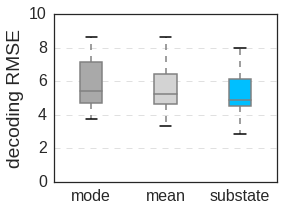

In [14]:
plt.rc('font', family='sans-serif', weight='normal')
plt.rc('xtick', labelsize='medium')
plt.rc('ytick', labelsize='medium')
plt.rc('font', size=16)
plt.rc('axes', labelsize='Large')

fig, ax = plt.subplots(1, 1, figsize=(4, 3))

import palettable
bmap = palettable.colorbrewer.qualitative.Pastel1_7
colors = bmap.mpl_colors
colors = ['darkgray','lightgray','deepskyblue'] # override colors
              
plot1 = plt.boxplot([errors_mode, errors_mean, errors_substate], labels=['mode','mean','substate'], patch_artist=True)
plt.ylim([0,10])
plt.ylabel('decoding RMSE')

plt.grid(axis='y',          # set y-axis grid lines
        linestyle='--',     # use dashed lines
        which='major',      # only major ticks
        color='lightgrey',  # line colour
        alpha=0.7)          # make lines semi-translucent

for ii, box in enumerate(plot1['boxes']):
    plt.setp(box, facecolor=colors[ii], 
             linewidth=1.5, 
             edgecolor='gray')

for ii, flier in enumerate(plot1['fliers']):
    plt.setp(flier, markerfacecolor=colors[ii], marker='o', markersize=7)

plt.setp(plot1['whiskers'], color='gray', linewidth=1.5)
plt.setp(plot1['caps'], color='black', linewidth=1.5)
#plt.setp(plot1['fliers'], markerfacecolor='orange', marker='.', markersize=10)
plt.setp(plot1['medians'], color='gray', linewidth=1.5)

#saveFigure('posterfigs/decspread.pdf')
#with plt.xkcd():

## Discussion and further comments

We saw that substate decoding indeed does have a slightly smaller decoding error than both the mode and mean decoding approaches. It might be interesting to understand how significant this difference will be for different models and choices of parameters. For example, if we only have a few states, then the coarse mean and mode positions are expected to be much worse than the more refined substate positions. Conversely, for a large number of states, there may be little gain in the substate decoding approach.

To be continued...